# Long Short Term Memory Model (LSTM) for predicting Global Active Power

In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [0]:
## Import the data and clean it up a bit

data = pd.read_csv("household_power_consumption.txt",sep = ";", parse_dates={'dt':['Date' , 'Time']},
                      infer_datetime_format=True, low_memory=False,na_values=['nan','?'], index_col='dt')

data['Global_active_power_shifted'] = data['Global_active_power'].drop(data['Global_active_power'].index[0])

data['Global_active_power_shifted'] = data['Global_active_power_shifted'].shift(-1)

data.drop(data.tail(1).index,inplace=True)

data = data.head(100000)

data = data.resample('h').mean()

In [79]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_shifted
dt,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,4.183278
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,3.653533
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,3.385833
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,3.270367
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,3.058967


In [75]:
## A bit more cleaning of the data along with normalization

data.dropna(inplace=True)

data_notarget = data.loc[:, data.columns != 'Global_active_power']

data_notarget.reset_index(drop=True)

testrate = 0.3
testX = np.array(data.iloc[:int(testrate*data.shape[0]),0:7])
trainX = np.array(data.iloc[int(testrate*data.shape[0]):,0:7])
testy = np.array(data.iloc[:int(data.shape[0]*testrate),7])
trainy = np.array(data.iloc[int(data.shape[0]*testrate):,7])

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(trainX)

trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(trainy.reshape(trainy.shape[0],1))

trainy = scaler2.transform(trainy.reshape(trainy.shape[0],1))
testy = scaler2.transform(testy.reshape(testy.shape[0],1))

testX = testX.reshape((testX.shape[0],1,7))
trainX = trainX.reshape((trainX.shape[0],1,7))

testy = testy.reshape((testy.shape[0],))
trainy = trainy.reshape((trainy.shape[0],))

np.arange(0,500).shape

(500,)

In [76]:
## Building an LSTM model using a Keras Sequential model and training

model = Sequential()
model.add(LSTM(5, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd)

model.fit(trainX, trainy, batch_size=70, epochs=20,shuffle=False,validation_data=(testX,testy))

Train on 1168 samples, validate on 500 samples
Epoch 1/20
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0249 - val_loss: 0.0181
Epoch 2/20
1168/1168 [==============================] - 0s 50us/step - loss: 0.0114 - val_loss: 0.0118
Epoch 3/20
1168/1168 [==============================] - 0s 45us/step - loss: 0.0066 - val_loss: 0.0072
Epoch 4/20
1168/1168 [==============================] - 0s 47us/step - loss: 0.0032 - val_loss: 0.0041
Epoch 5/20
1168/1168 [==============================] - 0s 43us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 6/20
1168/1168 [==============================] - 0s 49us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 7/20
1168/1168 [==============================] - 0s 44us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/20
1168/1168 [==============================] - 0s 45us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/20
1168/1168 [==============================] - 0s 47us/step - loss: 8.4756e-04 - val_loss: 0.0016
Epoch 10/20
1168/1168 [

In [97]:
## Predict unseen values using the model we just trained

predictions = model.predict(testX)

MSE = mean_squared_error(testy,predictions)

print("Mean Squared Error of true Global active power vs predicted: ", MSE)

predictions.shape = testy.shape
residual = (testy - predictions)

Mean Squared Error of true Global active power vs predicted:  0.00028754128880127683


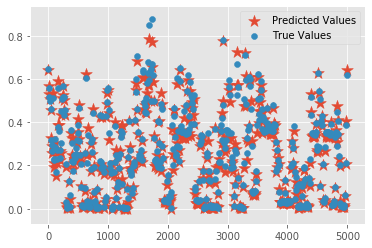

In [148]:
## Plot the true values vs the predicted values

fig = plt.figure()

xplot = np.arange(0,len(predictions)*10,10)
plt.scatter(xplot,predictions,label='Predicted Values',marker="*",s=150)
plt.scatter(xplot,testy,label='True Values')

plt.legend()

## The model performs quite well